In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D, Flatten, SimpleRNN, GRU, Dropout, LSTM, Bidirectional, Lambda
from tensorflow.keras.backend import sum
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
import urllib
import matplotlib.pyplot as plt
plt.style.use('default')


## **Classifição de artista musical baseado em letras de músicas**

### **Introdução:**
#### Esse projeto tem como objetivo desenvolver modelos de classificação que identifiquem um artista musical a partir de letras de músicas desses artistas, e comparar a performance desses diferentes modelos.
### **Dataset**:
#### O dataset utilizado possui 4167 diferentes artistas musicais, sendo que cada um deles possui entre uma até algumas centenas de letras de suas músicas.
#### Foram escolhidos 6 artistas, 3 de lingua inglesa (Eminem, The Beatles e Bob Dylan) e 3 de lingua portuguesa (Ivete Sangalo, Roberto Carlos e Chico Buarque), para criar os modelos de classificação.

In [2]:
dfArtists = pd.read_csv('artists-data.csv')
dfArtists.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [3]:
dfLyrics = pd.read_csv('lyrics-data.csv')
dfLyrics.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [4]:
selectedArtists = ['The Beatles', 'Eminem', 'Bob Dylan', 'Roberto Carlos', 'Ivete Sangalo', 'Chico Buarque' ]
nlabels = len(selectedArtists)
dfArtists = dfArtists[dfArtists["Artist"].isin(selectedArtists)]
sArtistsSeries =dfArtists['Link']
dfLyrics = dfLyrics[dfLyrics["ALink"].isin(sArtistsSeries)]


### Após selecionar os dados desejados, foram removidos os caracteres de quebra de linha, e foram definidas as stopwords, tanto em português quanto em ingles.

In [5]:
lyrics_original = list(dfLyrics['Lyric'])
labels = list(dfLyrics['ALink'])
lyrics = []
for l in lyrics_original:
    lyrics.append(l.replace('\n', ' '))


In [6]:
stopwords_list = urllib.request.urlopen("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").read().decode()
stopwords_en = set(stopwords_list.split()) 
stopwords_pt =  urllib.request.urlopen("https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt").read().decode()
stopwords_pt = set(stopwords_pt.split()) 
stowords_pt_eng = stopwords_en.union(stopwords_pt)
extra_sw_pt = set(["mi","yo","pro","vou", "pra","mim", "tá", "tô", "vai", "a","acerca","adeus","agora","ainda","alem","algmas","algo","algumas","alguns","ali","além","ambas","ambos","ano","anos","antes","ao","aonde","aos","apenas","apoio","apontar","apos","após","aquela","aquelas","aquele","aqueles","aqui","aquilo","as","assim","através","atrás","até","aí","baixo","bastante","bem","boa","boas","bom","bons","breve","cada","caminho","catorze","cedo","cento","certamente","certeza","cima","cinco","coisa","com","como","comprido","conhecido","conselho","contra","contudo","corrente","cuja","cujas","cujo","cujos","custa","cá","da","daquela","daquelas","daquele","daqueles","dar","das","de","debaixo","dela","delas","dele","deles","demais","dentro","depois","desde","desligado","dessa","dessas","desse","desses","desta","destas","deste","destes","deve","devem","deverá","dez","dezanove","dezasseis","dezassete","dezoito","dia","diante","direita","dispoe","dispoem","diversa","diversas","diversos","diz","dizem","dizer","do","dois","dos","doze","duas","durante","dá","dão","dúvida","e","ela","elas","ele","eles","em","embora","enquanto","entao","entre","então","era","eram","essa","essas","esse","esses","esta","estado","estamos","estar","estará","estas","estava","estavam","este","esteja","estejam","estejamos","estes","esteve","estive","estivemos","estiver","estivera","estiveram","estiverem","estivermos","estivesse","estivessem","estiveste","estivestes","estivéramos","estivéssemos","estou","está","estás","estávamos","estão","eu","exemplo","falta","fará","favor","faz","fazeis","fazem","fazemos","fazer","fazes","fazia","faço","fez","fim","final","foi","fomos","for","fora","foram","forem","forma","formos","fosse","fossem","foste","fostes","fui","fôramos","fôssemos","geral","grande","grandes","grupo","ha","haja","hajam","hajamos","havemos","havia","hei","hoje","hora","horas","houve","houvemos","houver","houvera","houveram","houverei","houverem","houveremos","houveria","houveriam","houvermos","houverá","houverão","houveríamos","houvesse","houvessem","houvéramos","houvéssemos","há","hão","iniciar","inicio","ir","irá","isso","ista","iste","isto","já","lado","lhe","lhes","ligado","local","logo","longe","lugar","lá","maior","maioria","maiorias","mais","mal","mas","me","mediante","meio","menor","menos","meses","mesma","mesmas","mesmo","mesmos","meu","meus","mil","minha","minhas","momento","muito","muitos","máximo","mês","na","nada","nao","naquela","naquelas","naquele","naqueles","nas","nem","nenhuma","nessa","nessas","nesse","nesses","nesta","nestas","neste","nestes","no","noite","nome","nos","nossa","nossas","nosso","nossos","nova","novas","nove","novo","novos","num","numa","numas","nunca","nuns","não","nível","nós","número","o","obra","obrigada","obrigado","oitava","oitavo","oito","onde","ontem","onze","os","ou","outra","outras","outro","outros","para","parece","parte","partir","paucas","pegar","pela","pelas","pelo","pelos","perante","perto","pessoas","pode","podem","poder","poderá","podia","pois","ponto","pontos","por","porque","porquê","portanto","posição","possivelmente","posso","possível","pouca","pouco","poucos","povo","primeira","primeiras","primeiro","primeiros","promeiro","propios","proprio","própria","próprias","próprio","próprios","próxima","próximas","próximo","próximos","puderam","pôde","põe","põem","quais","qual","qualquer","quando","quanto","quarta","quarto","quatro","que","quem","quer","quereis","querem","queremas","queres","quero","questão","quieto","quinta","quinto","quinze","quáis","quê","relação","sabe","sabem","saber","se","segunda","segundo","sei","seis","seja","sejam","sejamos","sem","sempre","sendo","ser","serei","seremos","seria","seriam","será","serão","seríamos","sete","seu","seus","sexta","sexto","sim","sistema","sob","sobre","sois","somente","somos","sou","sua","suas","são","sétima","sétimo","só","tal","talvez","tambem","também","tanta","tantas","tanto","tarde","te","tem","temos","tempo","tendes","tenha","tenham","tenhamos","tenho","tens","tentar","tentaram","tente","tentei","ter","terceira","terceiro","terei","teremos","teria","teriam","terá","terão","teríamos","teu","teus","teve","tinha","tinham","tipo","tive","tivemos","tiver","tivera","tiveram","tiverem","tivermos","tivesse","tivessem","tiveste","tivestes","tivéramos","tivéssemos","toda","todas","todo","todos","trabalhar","trabalho","treze","três","tu","tua","tuas","tudo","tão","tém","têm","tínhamos","um","uma","umas","uns","usa","usar","vai","vais","valor","veja","vem","vens","ver","verdade","verdadeiro","vez","vezes","viagem","vindo","vinte","você","vocês","vos","vossa","vossas","vosso","vossos","vários","vão","vêm","vós","zero","à","às","área","é","éramos","és","último"])
stowords_pt_eng = stowords_pt_eng.union(extra_sw_pt)

### Em sequência foi feito o Vectorizer das letras de músicas, e os dados foram separados em treino e teste.

In [7]:
vectorizer = CountVectorizer(stop_words = stowords_pt_eng, binary=True)
X = vectorizer.fit_transform(lyrics)

c:\Users\crazy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, random_state=37)

## **Modelos de Classificação:**
#### Serão utilizados 3 modelos de classificação para efeitos de comparação:
#### Naive Bayes, Regressão Logística e Redes Neurais(RNN simples, LSTM, e LSTM bidirecional)

### **Naive Bayes**

In [9]:
#Naive Bayes
model = BernoulliNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

     /bob-dylan/       0.59      0.99      0.74       144
 /chico-buarque/       0.96      0.24      0.38       114
        /eminem/       1.00      0.85      0.92       116
 /ivete-sangalo/       0.00      0.00      0.00        75
/roberto-carlos/       0.40      0.96      0.57       132
   /the-beatles/       0.00      0.00      0.00       105

        accuracy                           0.58       686
       macro avg       0.49      0.51      0.43       686
    weighted avg       0.53      0.58      0.48       686



c:\Users\crazy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\crazy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\crazy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

#### Com o Naive Bayes foi obtido um accuracy de 58%, que é melhor que um accuracy de 16,7% de um modelo completamente aleatório, porém é possível notar que no caso da Ivete Sangalo, tanto o precision quanto o recall foram 0, ou seja, esse modelo "ignorou" uma das categorias. 

#### É possível também analisar quais palavras foram mais influentes para cada categoria:

In [10]:
vocab = vectorizer.vocabulary_
palavras_BD = []
palavras_CB = []
palavras_Eminem = []
palavras_IS = []
palavras_RC = []
palavras_TB = []
for t in vocab.keys():
    prob_BD = model.feature_log_prob_[0, vocab[t]]
    palavras_BD.append( (prob_BD, t) )
    prob_CB = model.feature_log_prob_[1, vocab[t]]
    palavras_CB.append( (prob_CB, t) )
    prob_Eminem = model.feature_log_prob_[2, vocab[t]]
    palavras_Eminem.append( (prob_Eminem, t) )
    prob_IS = model.feature_log_prob_[3, vocab[t]]
    palavras_IS.append( (prob_IS, t) )
    prob_RC = model.feature_log_prob_[4, vocab[t]]
    palavras_RC.append( (prob_RC, t) )
    prob_TB = model.feature_log_prob_[5, vocab[t]]
    palavras_TB.append( (prob_TB, t) )
artists_list = [(palavras_BD, "Bob Dylan"), (palavras_Eminem, "Eminem"), (palavras_CB, "Chico Buarque"), (palavras_RC, "Roberto Carlos"), (palavras_IS, "Ivete Sangalo"), (palavras_TB, "The Beatles")]



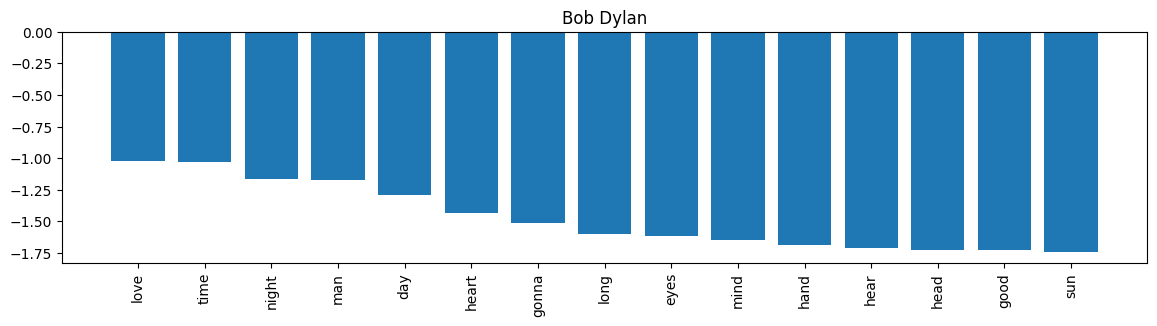

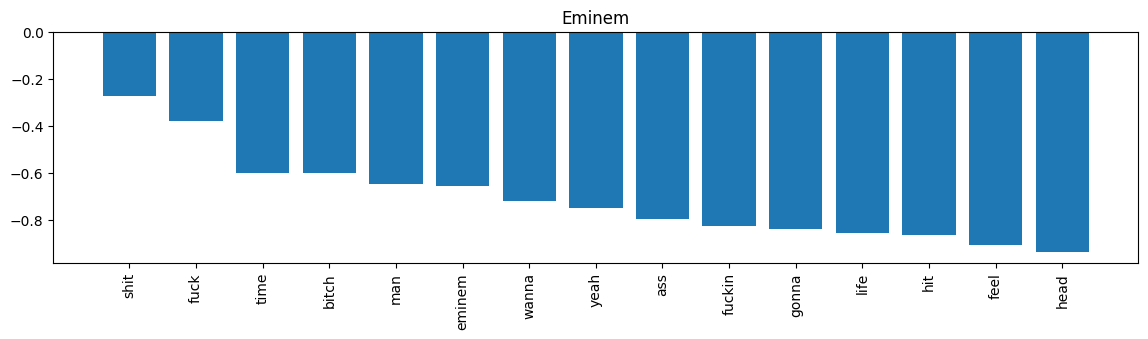

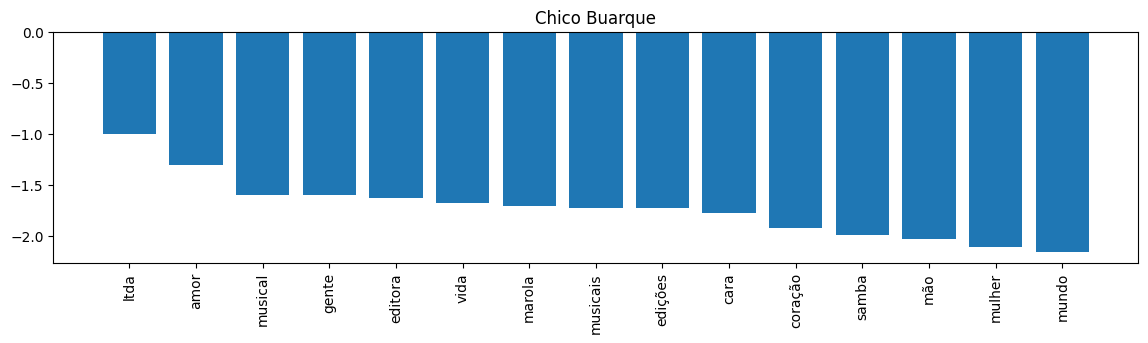

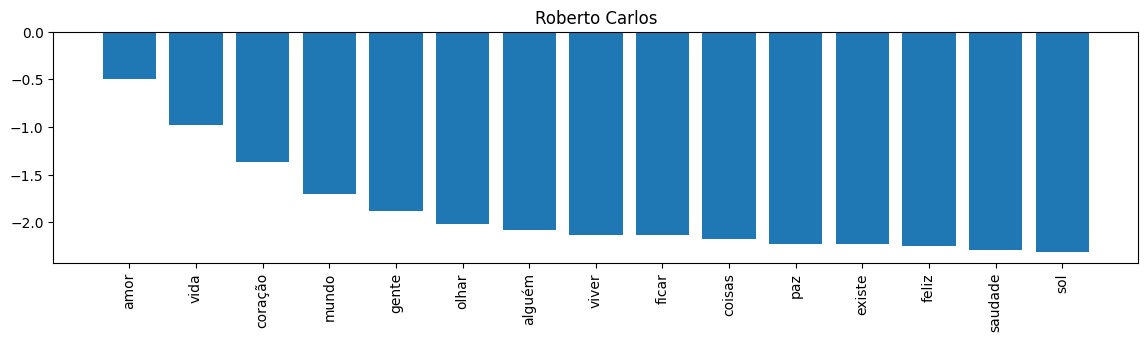

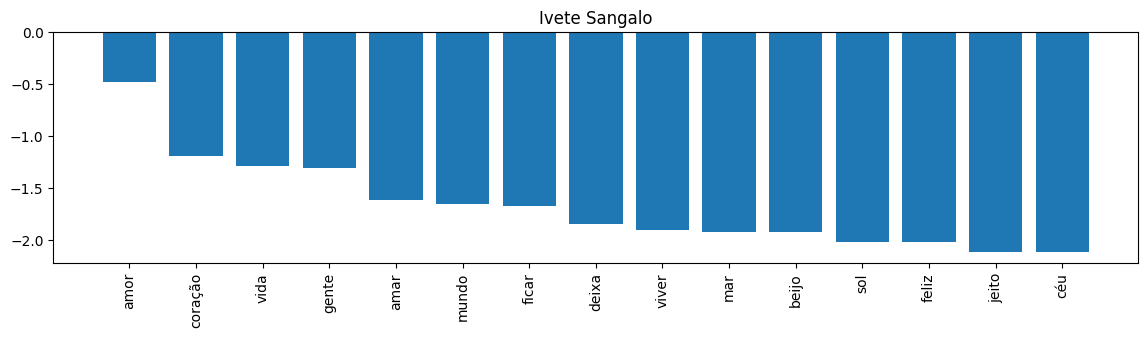

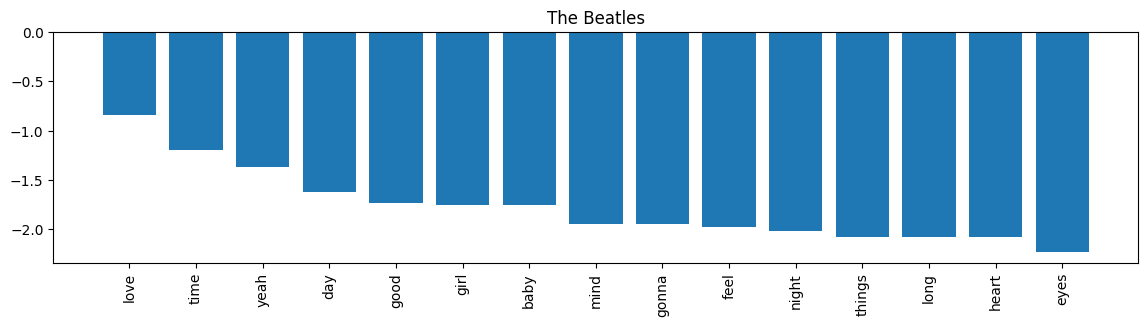

In [11]:
for artist in artists_list:
    tuplas_ordenadas = sorted(artist[0], reverse=True) # reverse=True pede uma ordenação em ordem decrescente
    palavras = [ t[1] for t in tuplas_ordenadas ]
    contagens = [ t[0] for t in tuplas_ordenadas ]

    n_palavras = 15
    eixo_x = np.arange(n_palavras)
    plt.figure(figsize=(14,3))
    plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
    plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=90)
    plt.title(f"{artist[1]}")
    plt.show()

#### As palavras mais influentes parecem fazer sentido com os respectivos artistas. Beatles e Bob Dylan possuem palavras como love, time, night, day entre as suas mais influentes, enquanto o rapper Eminem possui diversos palavrões típicos de suas músicas. O mesmo vale para os artistas brasileiros, que possuem palavas como amor, vida, coração, que são bastante presentes em suas letras.

### **Regressão Logística**

In [12]:
#Logistic Regression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(model_lr.classes_)

                  precision    recall  f1-score   support

     /bob-dylan/       0.78      0.89      0.83       144
 /chico-buarque/       0.92      0.71      0.80       114
        /eminem/       1.00      0.94      0.97       116
 /ivete-sangalo/       0.64      0.47      0.54        75
/roberto-carlos/       0.68      0.86      0.76       132
   /the-beatles/       0.67      0.66      0.66       105

        accuracy                           0.78       686
       macro avg       0.78      0.75      0.76       686
    weighted avg       0.79      0.78      0.78       686

['/bob-dylan/' '/chico-buarque/' '/eminem/' '/ivete-sangalo/'
 '/roberto-carlos/' '/the-beatles/']


#### Com a regressão logística foi obtido um accuracy de 78%, muito superior aos 16,7% de um modelo completamente aleatório, e aos 58% do Naive Bayes. Além disso nenhuma das categorias foi "ignorada" como ocorreu no Naive Bayes.

In [13]:
vocab = vectorizer.vocabulary_
palavras_BD = []
palavras_CB = []
palavras_Eminem = []
palavras_IS = []
palavras_RC = []
palavras_TB = []
for t in vocab.keys():
    prob_BD = model_lr.coef_[0, vocab[t]]
    if prob_BD > 0:
        palavras_BD.append( (prob_BD, t) )
    prob_CB = model_lr.coef_[1, vocab[t]]
    if prob_CB > 0:
        palavras_CB.append( (prob_CB, t) )
    prob_Eminem = model_lr.coef_[2, vocab[t]]
    if prob_Eminem > 0:
        palavras_Eminem.append( (prob_Eminem, t) )
    prob_IS = model_lr.coef_[3, vocab[t]]
    if prob_IS > 0:
        palavras_IS.append( (prob_IS, t) )
    prob_RC = model_lr.coef_[4, vocab[t]]
    if prob_RC:
        palavras_RC.append( (prob_RC, t) )
    prob_TB = model_lr.coef_[5, vocab[t]]
    if prob_TB:
        palavras_TB.append( (prob_TB, t) )
artists_list = [(palavras_BD, "Bob Dylan"), (palavras_Eminem, "Eminem"), (palavras_CB, "Chico Buarque"), (palavras_RC, "Roberto Carlos"), (palavras_IS, "Ivete Sangalo"), (palavras_TB, "The Beatles")]


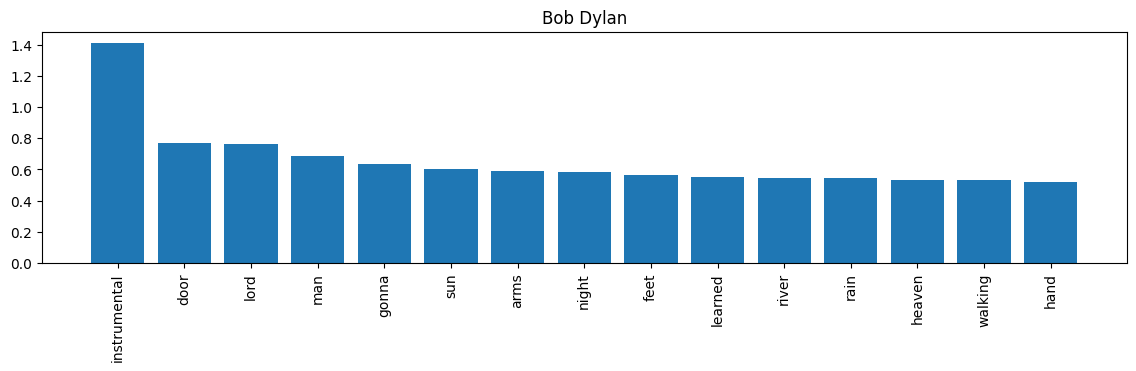

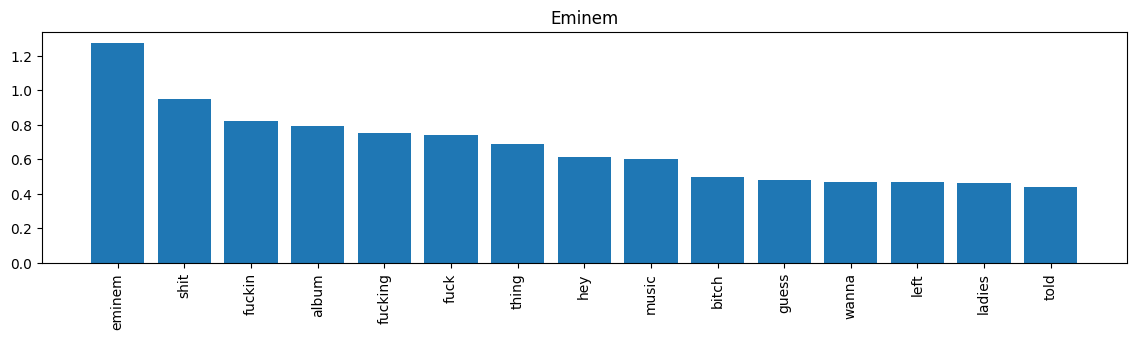

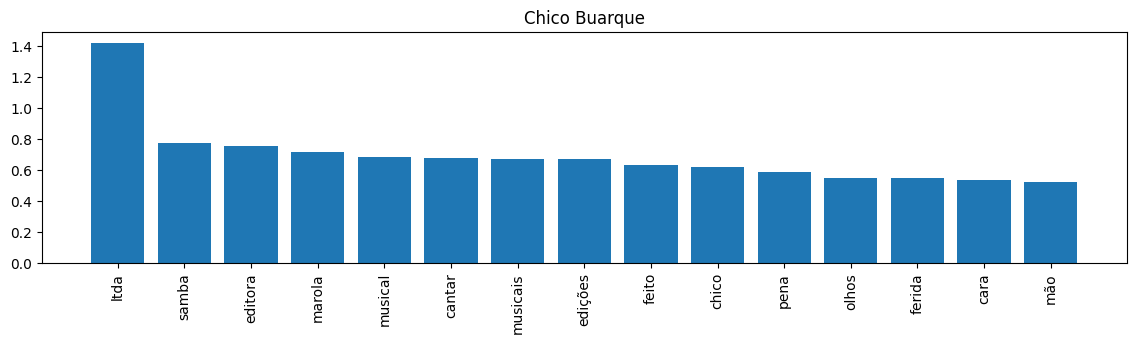

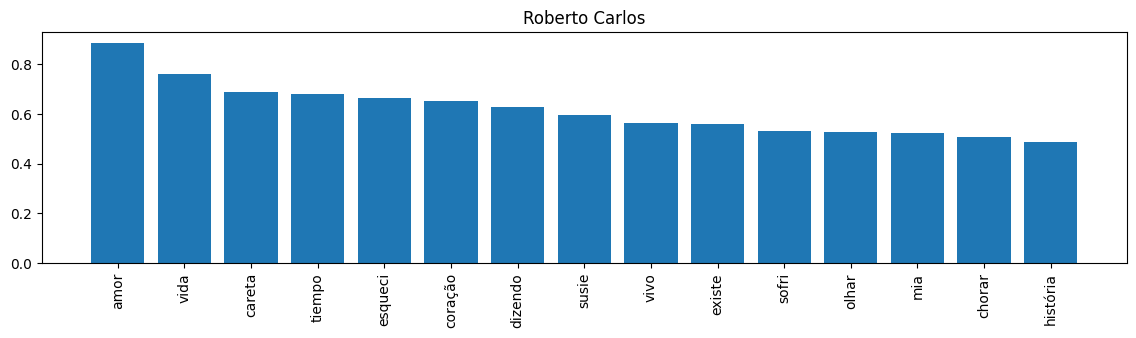

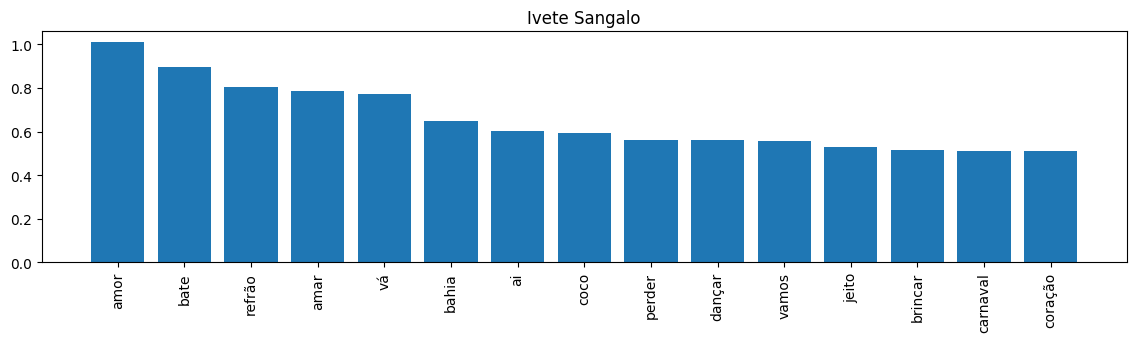

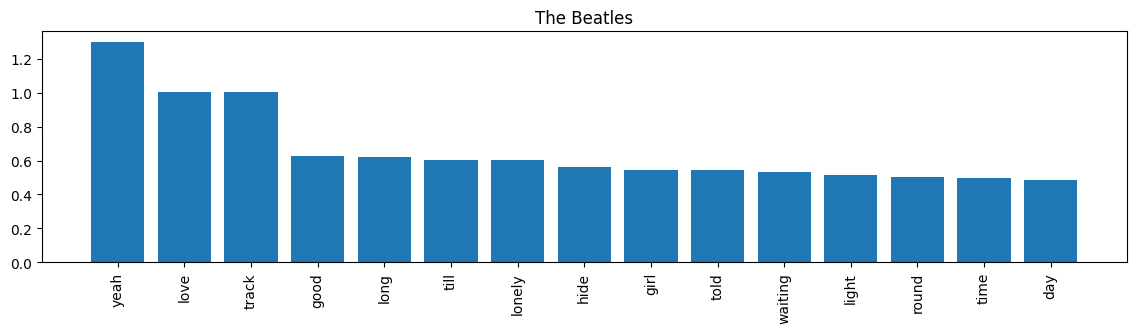

In [14]:
for artist in artists_list:
    tuplas_ordenadas = sorted(artist[0], reverse=True) # reverse=True pede uma ordenação em ordem decrescente
    palavras = [ t[1] for t in tuplas_ordenadas ]
    contagens = [ t[0] for t in tuplas_ordenadas ]

    n_palavras = 15
    eixo_x = np.arange(n_palavras)
    plt.figure(figsize=(14,3))
    plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
    plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=90)
    plt.title(f"{artist[1]}")
    plt.show()

#### As palavras mais relevantes para o modelo de regressão logística foram semelhantes às do naive bayes, com algumas diferenças pontuais e algumas trocas na ordem de importância.

### **Redes Neurais**
### **RNN Simples**
#### A primeira rede neural consiste em uma RNN com uma camada de Embedding, uma SimpleRNN e uma Dense com softmax. Além disso foi feito anteriormente a Tokenização, um padding e o One Hot Encoding das labels.

In [15]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(lyrics)
sequences = tokenizer.texts_to_sequences(lyrics)

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences,maxlen=1000)
ohe = OneHotEncoder()
labelsT = np.array(labels).T
labelsT = labelsT.reshape(-1,1)
y = ohe.fit_transform(labelsT).toarray()



In [17]:
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2)

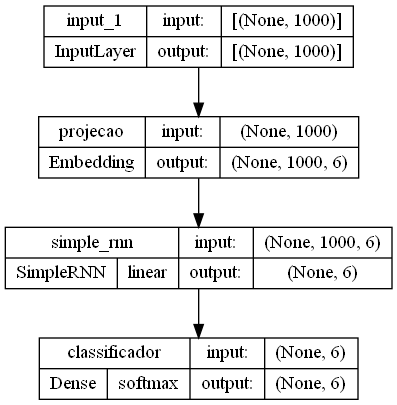

In [18]:
from keras.layers import SimpleRNN

def simpleRNN(input_dims):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 6, name='projecao')(x)
  x = SimpleRNN(6, activation='linear')(x)
  y = Dense(nlabels, activation='softmax', name='classificador')(x)
  return Model(input_layer, y)

rede_neural1 = simpleRNN(1000)
rede_neural1.compile(optimizer='adam', loss='mse')
plot_model(rede_neural1, show_shapes=True, show_layer_activations=True)

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural1.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=es)

Epoch 1/50
55/55 [==============================] - 16s 255ms/step - loss: 0.1262 - val_loss: 0.1112
Epoch 2/50
55/55 [==============================] - 14s 247ms/step - loss: 0.1054 - val_loss: 0.1086
Epoch 3/50
55/55 [==============================] - 14s 248ms/step - loss: 0.0956 - val_loss: 0.1026
Epoch 4/50
55/55 [==============================] - 14s 260ms/step - loss: 0.0892 - val_loss: 0.0998
Epoch 5/50
55/55 [==============================] - 14s 258ms/step - loss: 0.0798 - val_loss: 0.0984
Epoch 6/50
55/55 [==============================] - 14s 260ms/step - loss: 0.0746 - val_loss: 0.0989
Epoch 7/50
55/55 [==============================] - 13s 237ms/step - loss: 0.0805 - val_loss: 0.0956
Epoch 8/50
55/55 [==============================] - 14s 247ms/step - loss: 0.0695 - val_loss: 0.0975
Epoch 9/50
55/55 [==============================] - 14s 264ms/step - loss: 0.0616 - val_loss: 0.0957
Epoch 10/50
55/55 [==============================] - 14s 258ms/step - loss: 0.0575 - val_lo

In [20]:
y_est = rede_neural1.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

18/18 [==============================] - 1s 40ms/step
                  precision    recall  f1-score   support

     /bob-dylan/       0.38      0.94      0.54        89
 /chico-buarque/       0.66      0.44      0.53        96
        /eminem/       0.47      0.16      0.24        99
 /ivete-sangalo/       0.40      0.04      0.07        51
/roberto-carlos/       0.59      0.88      0.71       137
   /the-beatles/       0.31      0.06      0.11        77

        accuracy                           0.49       549
       macro avg       0.47      0.42      0.36       549
    weighted avg       0.49      0.49      0.42       549



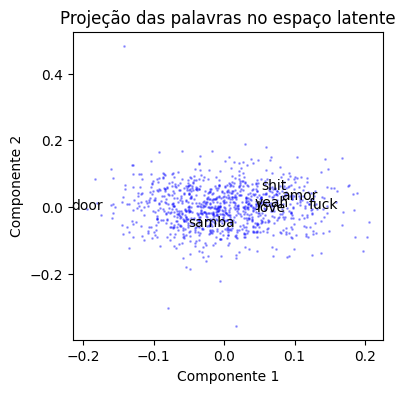

In [39]:
v_ = rede_neural1.get_layer('projecao').get_weights()[0]
proj = PCA(n_components=2)
v = proj.fit_transform(v_)

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["amor", "yeah", "love", "shit", "samba", "fuck", "door"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
plt.show()

#### O accuracy da RNN simples foi semelhante ao do naive bayes (49%), porém nenhuma categoria foi "ignorada".

#### A segunda rede neural consiste em uma RNN (LSTM) com uma camada de Embedding, uma LSTM, uma TimeDistributed, uma Lambda (aplicando a função de atenção) e uma Dense com softmax. 

In [40]:
def aplicar_atencao(par):
  estados, atencao = par[0], par[1]
  atencao_aplicada = estados * atencao
  contexto = sum(atencao_aplicada, axis=1)
  return contexto

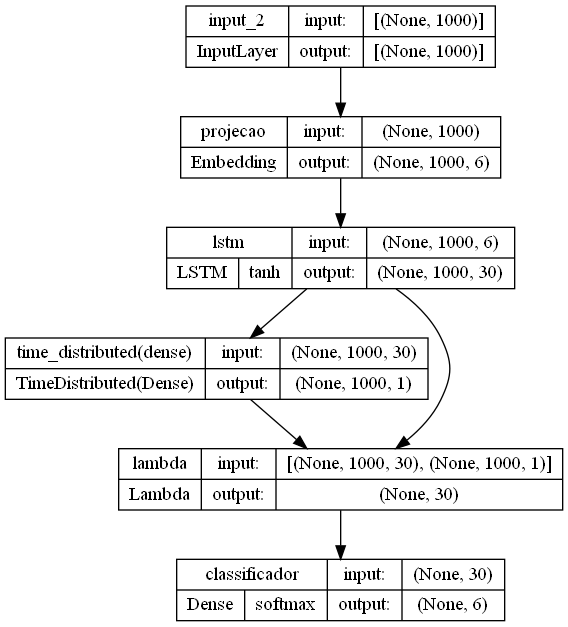

In [41]:
def rnnAttention(input_dims):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 6, name='projecao')(x)
  x = LSTM(30, return_sequences=True)(x)

  atencao = TimeDistributed(Dense(1, activation='sigmoid'))(x)
  contexto = Lambda(aplicar_atencao)( [x, atencao] )

  y = Dense(nlabels, activation='softmax', name='classificador')(contexto)
  return Model(input_layer, y), Model(input_layer, atencao)

rede_neural2, atencao = rnnAttention(1000)
rede_neural2.compile(optimizer='adam', loss='mse')
plot_model(rede_neural2, show_shapes=True, show_layer_activations=True)

In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural2.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=es)


Epoch 1/50
55/55 [==============================] - 32s 534ms/step - loss: 0.1334 - val_loss: 0.1189
Epoch 2/50
55/55 [==============================] - 26s 478ms/step - loss: 0.1052 - val_loss: 0.1095
Epoch 3/50
55/55 [==============================] - 27s 482ms/step - loss: 0.0932 - val_loss: 0.1032
Epoch 4/50
55/55 [==============================] - 26s 471ms/step - loss: 0.0834 - val_loss: 0.0882
Epoch 5/50
55/55 [==============================] - 26s 471ms/step - loss: 0.0768 - val_loss: 0.0873
Epoch 6/50
55/55 [==============================] - 26s 477ms/step - loss: 0.0707 - val_loss: 0.0773
Epoch 7/50
55/55 [==============================] - 26s 469ms/step - loss: 0.0666 - val_loss: 0.0779
Epoch 8/50
55/55 [==============================] - 33s 608ms/step - loss: 0.0621 - val_loss: 0.0746
Epoch 9/50
55/55 [==============================] - 38s 690ms/step - loss: 0.0640 - val_loss: 0.0856
Epoch 10/50
55/55 [==============================] - 37s 681ms/step - loss: 0.0601 - val_lo

In [43]:
y_est = rede_neural2.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

18/18 [==============================] - 4s 187ms/step
                  precision    recall  f1-score   support

     /bob-dylan/       0.64      0.85      0.73        89
 /chico-buarque/       0.66      0.81      0.73        96
        /eminem/       0.96      0.83      0.89        99
 /ivete-sangalo/       0.47      0.27      0.35        51
/roberto-carlos/       0.74      0.69      0.71       137
   /the-beatles/       0.59      0.55      0.57        77

        accuracy                           0.70       549
       macro avg       0.68      0.67      0.66       549
    weighted avg       0.70      0.70      0.70       549



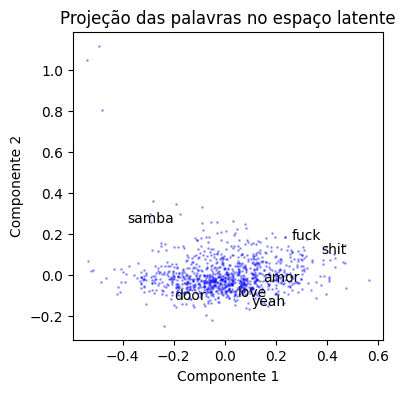

In [45]:
v_ = rede_neural2.get_layer('projecao').get_weights()[0]
proj = PCA(n_components=2)
v = proj.fit_transform(v_)

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["amor", "yeah", "love", "shit", "samba", "fuck", "door"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
plt.show()

In [46]:
at = atencao.predict(X_test)
words = tokenizer.sequences_to_texts(X_test)

18/18 [==============================] - 5s 210ms/step


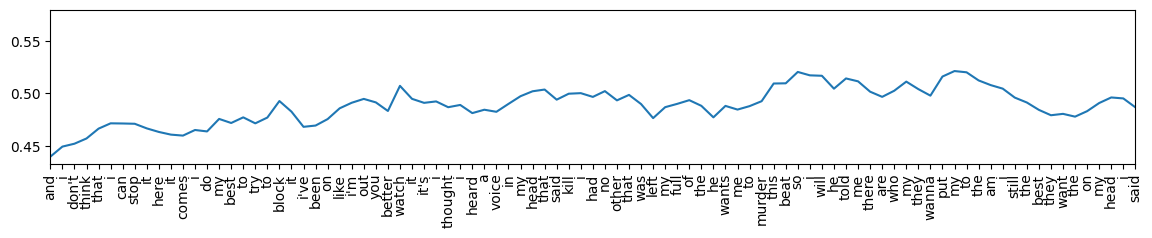

In [48]:
idx=30
plt.figure(figsize=(14,2))
n_words = len(words[idx].split())
at_ = at[idx,-n_words:]
plt.plot(at_)
plt.xticks(range(n_words), words[idx].split(), rotation=90)
plt.xlim([0,90])
plt.show()

#### O accuracy da RNN com atenção foi superior ao da RNN simples, alcançando 70%, mais próximo ao accuracy de 78% da regressão logística.

#### A terceira rede neural consiste em uma RNN com duas LSTM (bidirecional), uma camada de Embedding, uma LSTM, uma TimeDistributed, uma Lambda (aplicando a função de atenção) e uma Dense com softmax. 

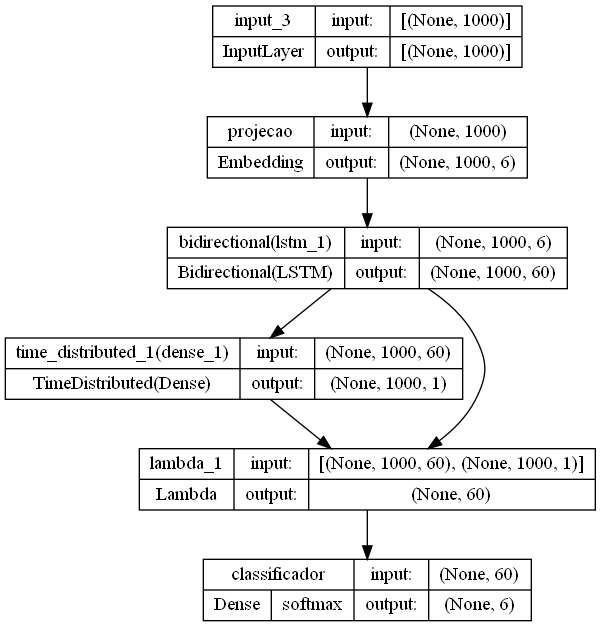

In [49]:
def rnnBidirectionalAttention(input_dims):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 6, name='projecao')(x)
  x_forward = LSTM(30, return_sequences=True)
  x_backward = LSTM(30, return_sequences=True, go_backwards=True)
  x = Bidirectional(x_forward, backward_layer=x_backward)(x)

  atencao = TimeDistributed(Dense(1, activation='sigmoid'))(x)
  contexto = Lambda(aplicar_atencao)( [x, atencao] )

  y = Dense(nlabels, activation='softmax', name='classificador')(contexto)
  return Model(input_layer, y), Model(input_layer, atencao)

rede_neural3, atencao3 = rnnBidirectionalAttention(1000)
rede_neural3.compile(optimizer='adam', loss='mse')
plot_model(rede_neural3, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [50]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural3.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=es)

Epoch 1/50
55/55 [==============================] - 52s 828ms/step - loss: 0.1975 - val_loss: 0.1758
Epoch 2/50
55/55 [==============================] - 44s 804ms/step - loss: 0.1729 - val_loss: 0.1781
Epoch 3/50
55/55 [==============================] - 43s 776ms/step - loss: 0.1681 - val_loss: 0.1582
Epoch 4/50
55/55 [==============================] - 40s 730ms/step - loss: 0.1411 - val_loss: 0.1387
Epoch 5/50
55/55 [==============================] - 40s 733ms/step - loss: 0.1215 - val_loss: 0.1252
Epoch 6/50
55/55 [==============================] - 40s 731ms/step - loss: 0.1160 - val_loss: 0.1330
Epoch 7/50
55/55 [==============================] - 40s 724ms/step - loss: 0.1111 - val_loss: 0.1233
Epoch 8/50
55/55 [==============================] - 40s 725ms/step - loss: 0.1100 - val_loss: 0.1210
Epoch 9/50
55/55 [==============================] - 40s 722ms/step - loss: 0.1022 - val_loss: 0.1109
Epoch 10/50
55/55 [==============================] - 39s 716ms/step - loss: 0.0895 - val_lo

In [51]:
y_est = rede_neural3.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

18/18 [==============================] - 6s 195ms/step
                  precision    recall  f1-score   support

     /bob-dylan/       0.68      0.85      0.76        89
 /chico-buarque/       0.79      0.80      0.80        96
        /eminem/       0.95      0.95      0.95        99
 /ivete-sangalo/       0.57      0.51      0.54        51
/roberto-carlos/       0.78      0.75      0.77       137
   /the-beatles/       0.70      0.57      0.63        77

        accuracy                           0.77       549
       macro avg       0.74      0.74      0.74       549
    weighted avg       0.77      0.77      0.76       549



#### O accuracy da RNN bidirecional foi o mais alto dentre as redes neurais, alcançando 77%, praticamente igual aos 78% da regressão logística.

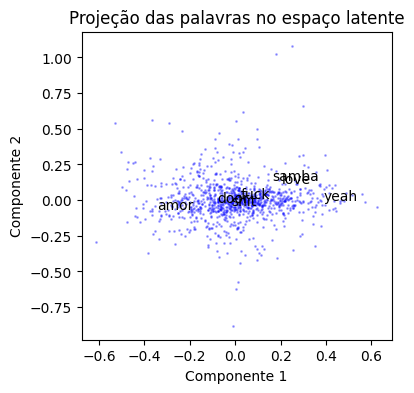

In [52]:
v_ = rede_neural3.get_layer('projecao').get_weights()[0]
proj = PCA(n_components=2)
v = proj.fit_transform(v_)

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["amor", "yeah", "love", "shit", "samba", "fuck", "door"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
plt.show()

18/18 [==============================] - 4s 195ms/step


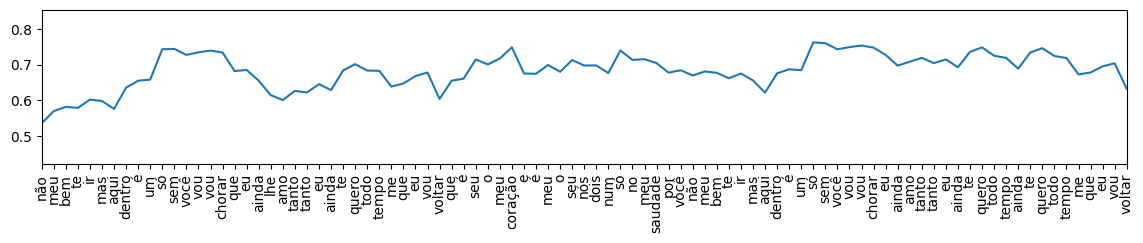

In [54]:
at2 = atencao3.predict(X_test)
idx=15
plt.figure(figsize=(14,2))
n_words = len(words[idx].split())
at_2 = at2[idx,-n_words:]
plt.plot(at_2)
plt.xticks(range(n_words), words[idx].split(), rotation=90)
plt.xlim([0,90])
plt.show()


## **Conclusão:**

#### Entre os modelos testados, o que teve o maior accuracy foi a Regressão Logística, com 78%, praticamente empatada com a RNN bidirecional, com 77% de accuracy. Apesar da complexidade da RNN bidirecional com atenção, seu accuracy não foi superior à Regressão Logística. Uma possível explicação para esse fenômeno é a baixa quantidade de dados, uma vez que cada categoria (artista musical) possuia no máximo algumas centenas de letras musicais, valores esses considerados baixos para o treinamento de redes neurais profundas. É possível que com uma maior quantidade de dados a performance das RNNs fosse ainda maior. 

#### É importante destacar que a accuracy tende a aumentar quando os artistas possuem características únicas dentro do grupo escolhido. Nos exemplos escolhidos, o artista Eminem era o único rapper e o único que constantemente utiliza palavrões em suas letras, portanto todos modelos obtiveram uma alta performance em identificá-lo. O inverso também é verdade, se todos artistas escolhidos possuissem estilos musicais muito semelhantes, a accuracy provavelmente seria menor.
